In [241]:
import pandas
import torch
import torch.nn as nn
import torch.optim as optim
from dataclasses import dataclass, field
from pathlib import Path
import numpy
import seaborn
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

seaborn.set_style("whitegrid")

## Parsing and preparation

In [242]:
@dataclass(eq=True, order=True, frozen=True)
class Point:
    patient_id: str
    replica: str
    timepoint: str

In [243]:
data_path = Path("../data/")

In [244]:
data_tables = dict()
for file_path in data_path.iterdir():
    if file_path.match("BH_*ts_*_rep*.vcfsnpEff_genes.txt"):
        file_name = file_path.name
        point = Point(
            patient_id=file_path.name.split("_")[1][:-2],
            replica=file_path.name.split("_")[3].split(".")[0][3:],
            timepoint=file_path.name.split("_")[2]
        )
        data_tables[point] = pandas.read_csv(file_path, sep="\t", header=1)

In [245]:
# data_tables[Point("1", "1", "1")]

In [246]:
genes_set = set()
for point, data_frame in data_tables.items():
    genes_set = genes_set.union(set(data_frame["GeneId"]))

In [247]:
vector_size = len(genes_set)
genes_to_idx = {g_name: idx for idx, g_name in enumerate(genes_set)}

In [248]:
vector_size

615

In [249]:
points = list()
ordered_patients_points = []
for point, data_frame in data_tables.items():
    ordered_patients_points.append(point)
    gene_vector = numpy.zeros(vector_size)
    for gene_name, idx in genes_to_idx.items():
        gene_presence = numpy.sum(
            data_frame[
            data_frame["GeneId"] == gene_name
            ][
            ["variants_impact_HIGH", "variants_impact_MODERATE"]
            ].to_numpy()
        )
        if gene_presence:
            gene_vector[idx] = 1
    points.append(gene_vector)

In [250]:
points = numpy.array(points)

In [251]:
points.shape

(40, 615)

## Embeddings

In [323]:
epochs_number = 3000

In [324]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embedding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [325]:
masking_probabilities = numpy.random.normal(0.1, 0.01, epochs_number)
masking_probabilities[masking_probabilities < 0] = 0
masking_probabilities[masking_probabilities > 1] = 1
min(masking_probabilities), max(masking_probabilities)

(0.06464764897513425, 0.1354012692359388)

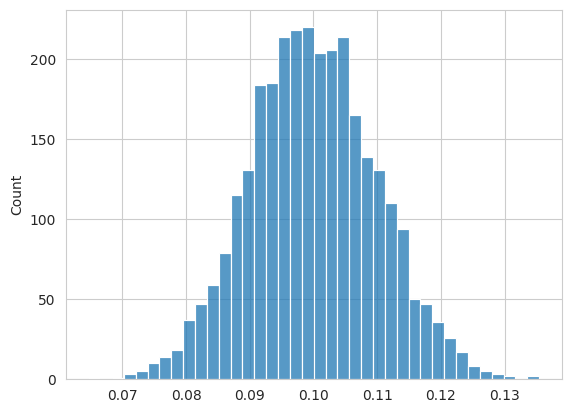

In [326]:
mask_prob_hist_figure = seaborn.histplot(masking_probabilities)

In [327]:
data = torch.from_numpy(points).float()

In [335]:
input_dim = data.shape[1]
hidden_dims = 128
embedding_dim = 16


model = Autoencoder(input_dim, hidden_dims, embedding_dim)
criterion = nn.MSELoss()


In [336]:
loss_values = []
optimizer = optim.Adam(model.parameters(), lr=0.003)
for epoch in range(epochs_number):
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch + 1}/{epochs_number}], Loss: {loss.item():.4f}")

    mask_prob = masking_probabilities[epoch]

    mask = torch.rand_like(data) > mask_prob
    masked_data = data * mask

    outputs = model(masked_data)
    loss = criterion(outputs, data)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_values.append(loss.item())


Epoch [100/3000], Loss: 0.0376
Epoch [200/3000], Loss: 0.0179
Epoch [300/3000], Loss: 0.0103
Epoch [400/3000], Loss: 0.0093
Epoch [500/3000], Loss: 0.0090
Epoch [600/3000], Loss: 0.0087
Epoch [700/3000], Loss: 0.0087
Epoch [800/3000], Loss: 0.0085
Epoch [900/3000], Loss: 0.0084
Epoch [1000/3000], Loss: 0.0086
Epoch [1100/3000], Loss: 0.0082
Epoch [1200/3000], Loss: 0.0080
Epoch [1300/3000], Loss: 0.0079
Epoch [1400/3000], Loss: 0.0079
Epoch [1500/3000], Loss: 0.0078
Epoch [1600/3000], Loss: 0.0078
Epoch [1700/3000], Loss: 0.0079
Epoch [1800/3000], Loss: 0.0076
Epoch [1900/3000], Loss: 0.0076
Epoch [2000/3000], Loss: 0.0076
Epoch [2100/3000], Loss: 0.0075
Epoch [2200/3000], Loss: 0.0074
Epoch [2300/3000], Loss: 0.0075
Epoch [2400/3000], Loss: 0.0074
Epoch [2500/3000], Loss: 0.0074
Epoch [2600/3000], Loss: 0.0074
Epoch [2700/3000], Loss: 0.0073
Epoch [2800/3000], Loss: 0.0071
Epoch [2900/3000], Loss: 0.0070
Epoch [3000/3000], Loss: 0.0070


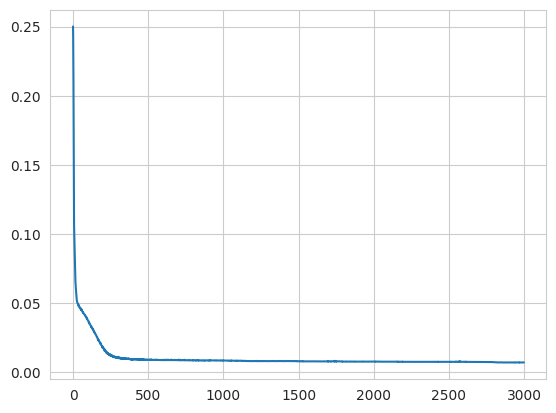

In [337]:
loss_plot = seaborn.lineplot(loss_values)

In [338]:
embeddings = model.encoder(data).detach().numpy()

In [339]:
pca = PCA(n_components=2)
pca.fit(embeddings)

PCA(n_components=2)

In [340]:
components = pca.fit_transform(embeddings)

points_2d_dict = {
    "pca0": components.T[0],
    "pca1": components.T[1],
    "patient": [patient.patient_id for patient in ordered_patients_points],
    "timepoint": [patient.timepoint for patient in ordered_patients_points]
}

data_2d = pandas.DataFrame.from_dict(points_2d_dict)


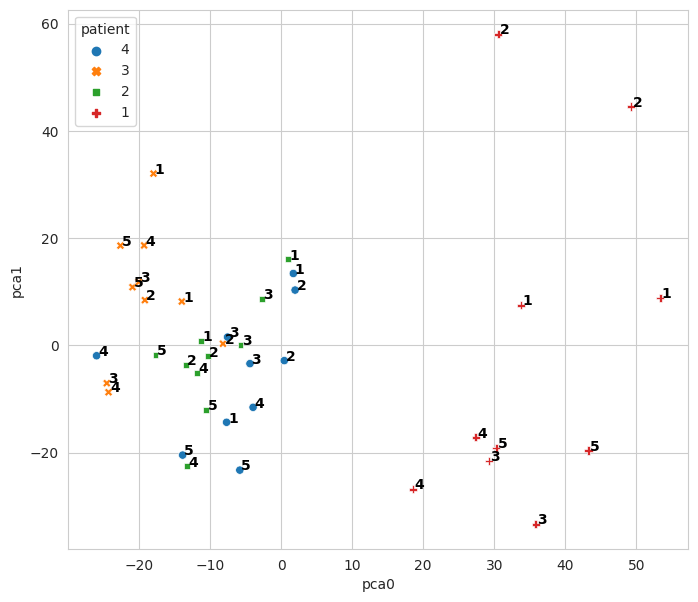

In [341]:
f, ax = plt.subplots(figsize=(8, 7))
fig = seaborn.scatterplot(data_2d, x="pca0", y="pca1", hue="patient", style="patient")

for line in range(0, data_2d.shape[0]):
     plt.text(
         data_2d.pca0[line]+0.2, 
         data_2d.pca1[line], 
         data_2d.timepoint[line], 
         horizontalalignment='left', 
         size='medium', 
         color='black', 
         weight='semibold'
     )



## Flow calculation

In [387]:
mean_x_for_patient_for_timepoint = {}
mean_y_for_patient_for_timepoint = {}
for point in ordered_patients_points:
    patient_id, timepoint = point.patient_id, point.timepoint
    subdata = data_2d[numpy.logical_and(data_2d["patient"] == patient_id, data_2d["timepoint"] == timepoint)]
    x_mean = numpy.mean(subdata["pca0"])
    y_mean = numpy.mean(subdata["pca1"])
    mean_x_for_patient_for_timepoint[(patient_id, timepoint)] = x_mean
    mean_y_for_patient_for_timepoint[(patient_id, timepoint)] = y_mean

In [388]:
coord_x = []
coord_y = []
velocity_x = []
velocity_y = []
for idx, point in enumerate(ordered_patients_points):
    x, y = components[idx]
    v_x, v_y = 0, 0
    if (point.patient_id, str(int(point.timepoint) + 1)) in mean_x_for_patient_for_timepoint:
        v_x = mean_x_for_patient_for_timepoint[(point.patient_id, str(int(point.timepoint) + 1))] - x
        v_y = mean_y_for_patient_for_timepoint[(point.patient_id, str(int(point.timepoint) + 1))] - y
    coord_x.append(x)
    coord_y.append(y)
    velocity_x.append(v_x)
    velocity_y.append(v_y)
    

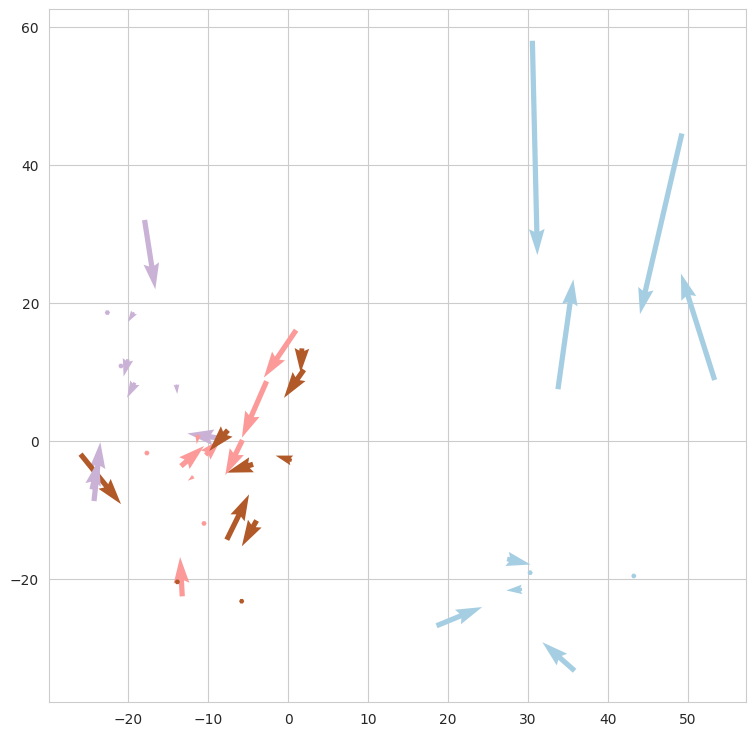

In [390]:
x = numpy.array(coord_x)
y = numpy.array(coord_y)
dx = numpy.array(velocity_x)
dy = numpy.array(velocity_y)

plt.rcParams['image.cmap'] = 'Paired'

fig, ax = plt.subplots(figsize =(9, 9))

ax.quiver(
    x, 
    y, 
    dx, 
    dy, 
    [int(patient.patient_id) for patient in ordered_patients_points], 
    units='width'
)


plt.show()

## Points bootstrap

In [443]:
n = 20
bootstrapped_data = []
for mask_prob in masking_probabilities[:n]:
    mask = torch.rand_like(data) > mask_prob * 3
    bootstrapped_data.append(data * mask)


In [444]:
bootstrapped_embeddings = model.encoder(torch.cat(bootstrapped_data, 0)).detach().numpy()

In [445]:
pca = PCA(n_components=2)
pca.fit(bootstrapped_embeddings)

PCA(n_components=2)

In [446]:
bootstrapped_components = pca.fit_transform(bootstrapped_embeddings)

bootstrapped_points_2d_dict = {
    "pca0": bootstrapped_components.T[0],
    "pca1": bootstrapped_components.T[1],
    "patient": [patient.patient_id for patient in ordered_patients_points] * n,
    "timepoint": [patient.timepoint for patient in ordered_patients_points] * n
}

bootstrapped_data_2d = pandas.DataFrame.from_dict(bootstrapped_points_2d_dict)


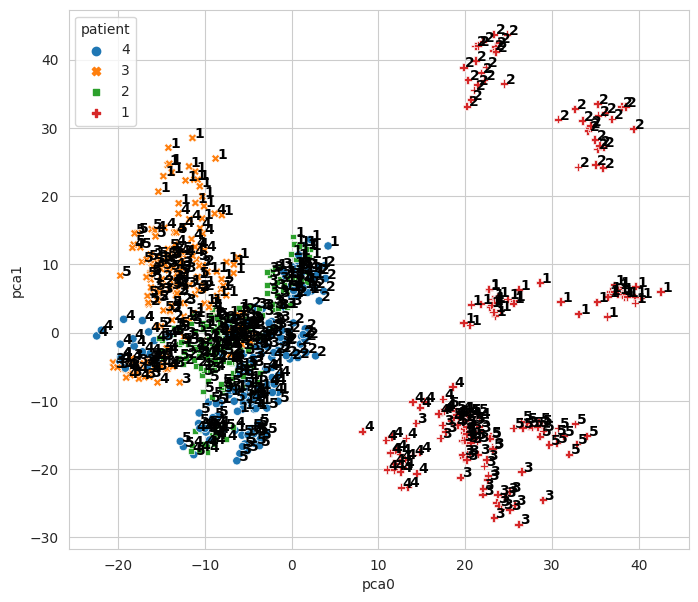

In [447]:
f, ax = plt.subplots(figsize=(8, 7))
fig = seaborn.scatterplot(bootstrapped_data_2d, x="pca0", y="pca1", hue="patient", style="patient")

for line in range(0, bootstrapped_data_2d.shape[0]):
     plt.text(
         bootstrapped_data_2d.pca0[line]+0.2, 
         bootstrapped_data_2d.pca1[line], 
         bootstrapped_data_2d.timepoint[line], 
         horizontalalignment='left', 
         size='medium', 
         color='black', 
         weight='semibold'
     )

## Bootstraped flow

In [441]:
def draw_flow():
    mean_x_for_patient_for_timepoint = {}
    mean_y_for_patient_for_timepoint = {}
    for point in ordered_patients_points:
        patient_id, timepoint = point.patient_id, point.timepoint
        subdata = bootstrapped_data_2d[numpy.logical_and(
            bootstrapped_data_2d["patient"] == patient_id, 
            bootstrapped_data_2d["timepoint"] == timepoint
        )]
        x_mean = numpy.mean(subdata["pca0"])
        y_mean = numpy.mean(subdata["pca1"])
        mean_x_for_patient_for_timepoint[(patient_id, timepoint)] = x_mean
        mean_y_for_patient_for_timepoint[(patient_id, timepoint)] = y_mean
    
    coord_x = []
    coord_y = []
    velocity_x = []
    velocity_y = []
    for idx, point in enumerate(ordered_patients_points * n):
        x, y = bootstrapped_components[idx]
        v_x, v_y = 0, 0
        if (point.patient_id, str(int(point.timepoint) + 1)) in mean_x_for_patient_for_timepoint:
            v_x = mean_x_for_patient_for_timepoint[(point.patient_id, str(int(point.timepoint) + 1))] - x
            v_y = mean_y_for_patient_for_timepoint[(point.patient_id, str(int(point.timepoint) + 1))] - y
        coord_x.append(x)
        coord_y.append(y)
        velocity_x.append(v_x)
        velocity_y.append(v_y)

    x = numpy.array(coord_x)
    y = numpy.array(coord_y)
    dx = numpy.array(velocity_x)
    dy = numpy.array(velocity_y)
    
    plt.rcParams['image.cmap'] = 'Accent'
    
    fig, ax = plt.subplots(figsize =(10, 10))

    ax.quiver(
        x, 
        y, 
        dx * 2, 
        dy * 2, 
        [int(patient.patient_id) for patient in ordered_patients_points] * n, 
        units='width'
    )
    
    # for line in range(0, bootstrapped_data_2d.shape[0]):
    #  plt.text(
    #      bootstrapped_data_2d.pca0[line]+0.2, 
    #      bootstrapped_data_2d.pca1[line], 
    #      bootstrapped_data_2d.timepoint[line], 
    #      horizontalalignment='left', 
    #      size='medium', 
    #      color='black', 
    #      weight='semibold'
    #  )
    
    plt.show()

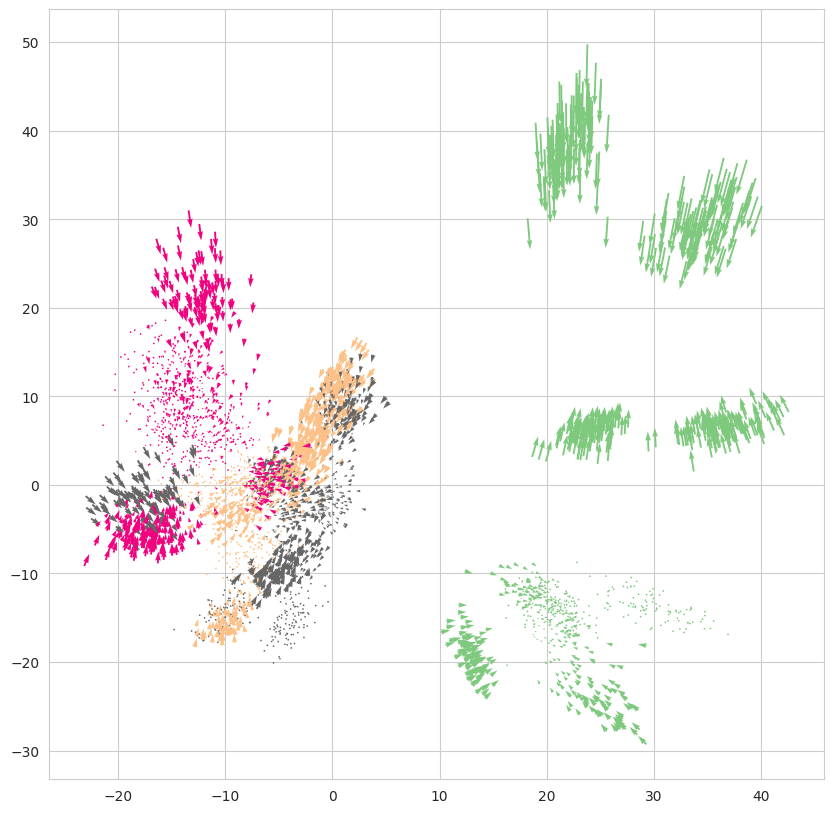

In [442]:
draw_flow()